<a href="https://colab.research.google.com/github/rishikam23/-Wine-Quality-Clustering-Analysis/blob/main/Wine%20Quality%20Clustering%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
sns.set(style="whitegrid")

In [47]:
#Loading the Wine Quality dataset
url="/content/drive/MyDrive/winequality-white.csv"
df=pd.read_csv(url,sep=';')

In [48]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [33]:
def normalize(df):
    scaler=MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

def log_transform(df):
    return pd.DataFrame(np.log1p(df),columns=df.columns)

def apply_pca(df, n=2):
    pca=PCA(n_components=n)
    return pd.DataFrame(pca.fit_transform(df),columns=[f"PC{i+1}" for i in range(n)])

In [34]:
#Defining preprocessing pipelines
preprocessed_data={"No Data Processing":df,"Using Normalization":normalize(df),"Using Transform":log_transform(df),
               "Using PCA":apply_pca(normalize(df)),"Using T+N":normalize(log_transform(df)),"T+N+PCA":apply_pca(normalize(log_transform(df)))}

In [35]:
#Evaluation of the algorithnms
results=[]
for i in ["KMeans","Hierarchical"]:
    for prep_name,data in preprocessed_data.items():
        for c in [3,4,5]:
            if i=="KMeans":
                model=KMeans(n_clusters=c,random_state=0)
            else:
                model=AgglomerativeClustering(n_clusters=c)
            labels=model.fit_predict(data)
            silhouette=silhouette_score(data,labels)
            ch=calinski_harabasz_score(data,labels)
            db=davies_bouldin_score(data,labels)
            results.append({
                "Algorithm":i,
                "Preprocessing":prep_name,
                "Clusters":c,
                "Silhouette":round(silhouette,3),
                "Calinski-Harabasz":round(ch),
                "Davies-Bouldin":round(db,3)
            })

In [36]:
for prep_name,data in preprocessed_data.items():
    model=MeanShift()
    labels=model.fit_predict(data)
    c=len(np.unique(labels))
    if c>=2:
        silhouette=silhouette_score(data,labels)
        ch=calinski_harabasz_score(data,labels)
        db=davies_bouldin_score(data,labels)
        results.append({
            "Algorithm":"MeanShift",
            "Preprocessing":prep_name,
            "Clusters":c,
            "Silhouette":round(silhouette,3),
            "Calinski-Harabasz":round(ch),
            "Davies-Bouldin":round(db,3)
        })
    else:
        print(f"MeanShift found only 1 cluster for preprocessing: {prep_name}. Skipping metric calculation.")

MeanShift found only 1 cluster for preprocessing: Using PCA. Skipping metric calculation.


In [37]:
#Results table
results_df=pd.DataFrame(results)
results_df.head()

,Algorithm,Preprocessing,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans,No Data Processing,3,0.412,6815,0.784
1,KMeans,No Data Processing,4,0.374,6507,0.840
2,KMeans,No Data Processing,5,0.343,6035,0.910
3,KMeans,Using Normalization,3,0.170,1221,1.868
4,KMeans,Using Normalization,4,0.137,976,2.072


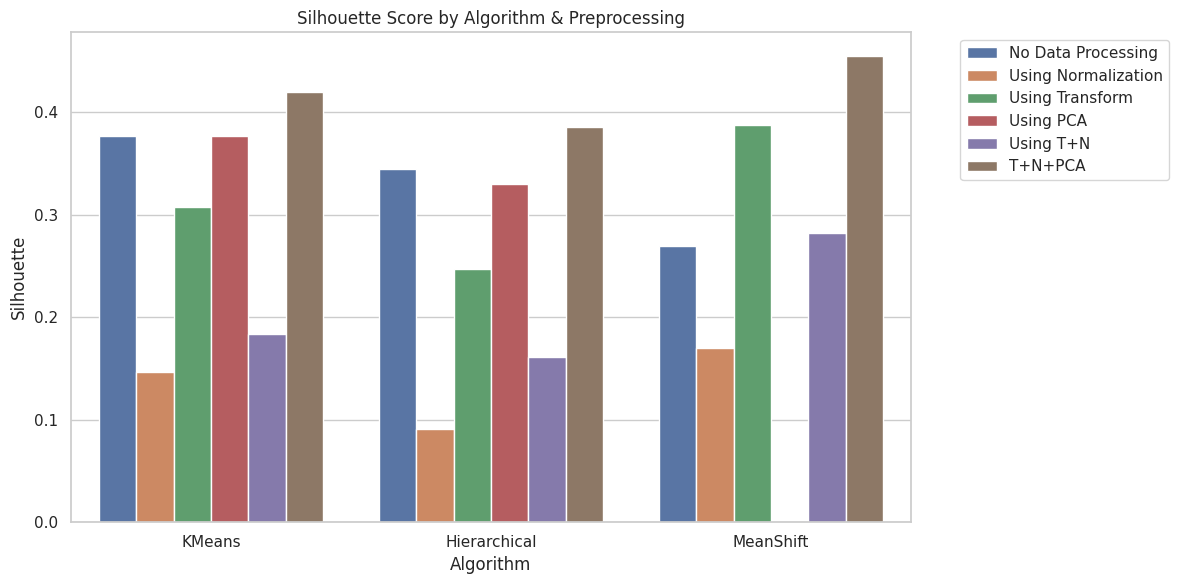

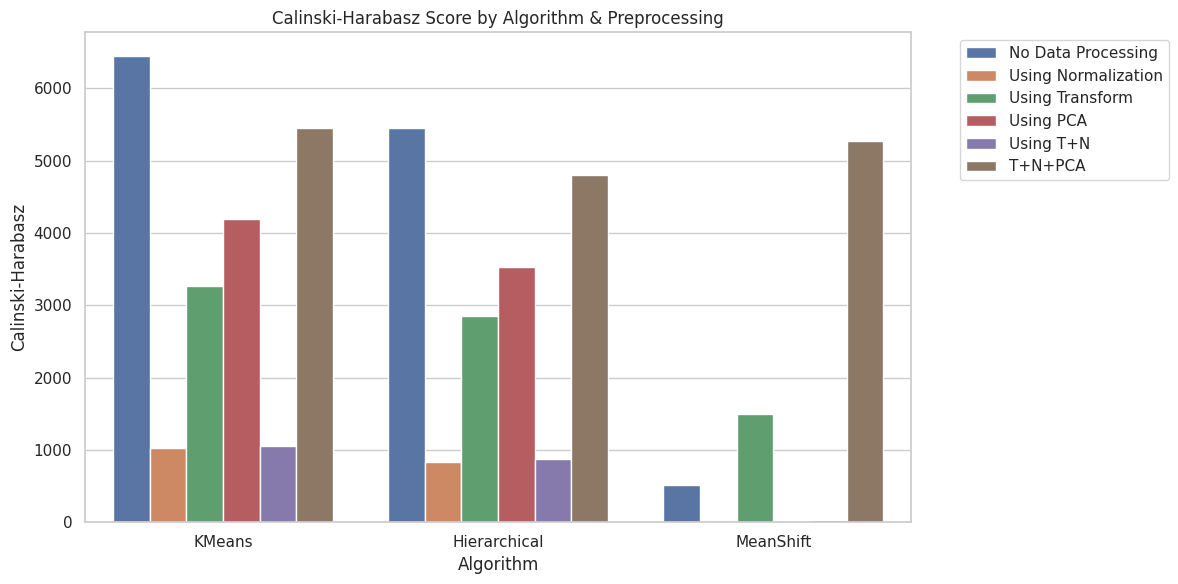

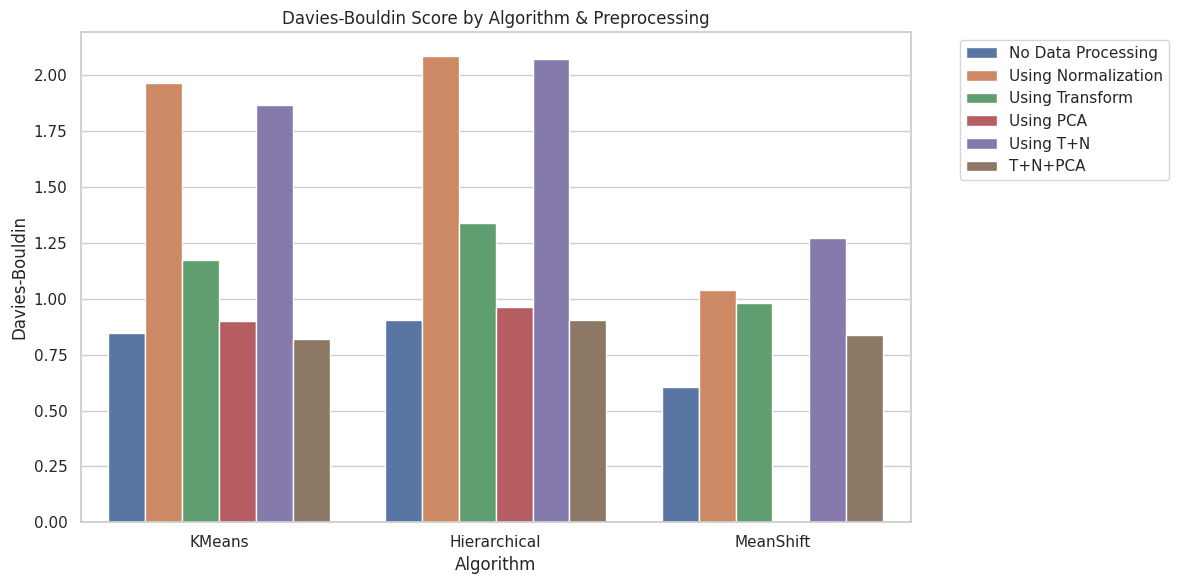

In [41]:
#Visualizations
#Metric comparison barplot
metrics=["Silhouette","Calinski-Harabasz","Davies-Bouldin"]
for m in metrics:
    plt.figure(figsize=(12,6))
    sns.barplot(data=results_df,x="Algorithm",y=m,hue="Preprocessing",errorbar=None)
    plt.title(f"{m} Score by Algorithm & Preprocessing")
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

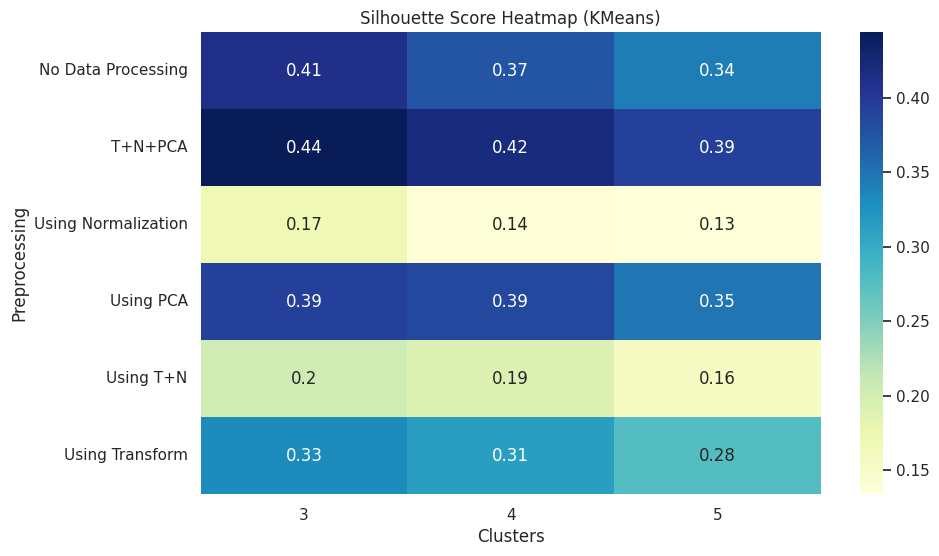

In [39]:
#Heatmap of silhouette scores across preprocessing and cluster count (KMeans)
kmeans_data=results_df[(results_df["Algorithm"]== "KMeans")]
pivot=kmeans_data.pivot(index="Preprocessing",columns="Clusters",values="Silhouette")
plt.figure(figsize=(10,6))
sns.heatmap(pivot,annot=True,cmap="YlGnBu")
plt.title("Silhouette Score Heatmap (KMeans)")
plt.show()

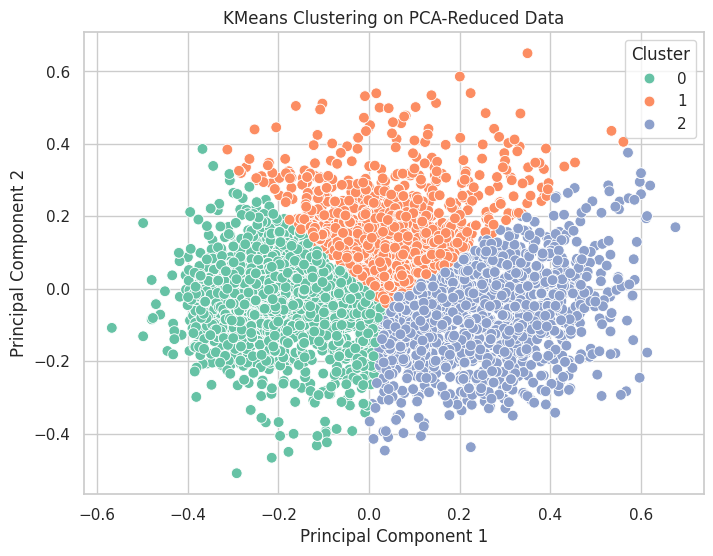

In [49]:
#Cluster scatter plot
data_pca=apply_pca(normalize(df))
model_kmeans=KMeans(n_clusters=3,random_state=0)
labels=model_kmeans.fit_predict(data_pca)
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_pca["PC1"],y=data_pca["PC2"],hue=labels, palette="Set2",s=60)
plt.title("KMeans Clustering on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [44]:
#Saving to csv file
results_df.to_csv("wine_clustering_results.csv",index=False)

In [51]:
#Displaying results
def pivot_metric(metric):
    temp=results_df[results_df["Algorithm"].isin(["KMeans","Hierarchical"])]
    return temp.pivot_table(index=["Algorithm", "Preprocessing"],columns="Clusters",values=metric).round(3).reset_index()

silhouette_table=pivot_metric("Silhouette")
ch_table=pivot_metric("Calinski-Harabasz").round(0)
db_table=pivot_metric("Davies-Bouldin")

print("Silhouette Score Table:")
display(silhouette_table)

print("\nCalinski-Harabasz Score Table:")
display(ch_table)

print("\nDavies-Bouldin Score Table:")
display(db_table)

print("\nMeanShift Results Table:")
meanshift_table=results_df[results_df["Algorithm"]=="MeanShift"][["Preprocessing","Clusters","Silhouette","Calinski-Harabasz","Davies-Bouldin"]].round(3)
display(meanshift_table)

Silhouette Score Table:


Clusters,Algorithm,Preprocessing,3,4,5
0,Hierarchical,No Data Processing,0.394,0.338,0.302
1,Hierarchical,T+N+PCA,0.434,0.389,0.333
2,Hierarchical,Using Normalization,0.106,0.096,0.072
3,Hierarchical,Using PCA,0.368,0.318,0.303
4,Hierarchical,Using T+N,0.174,0.168,0.140
5,Hierarchical,Using Transform,0.269,0.249,0.223
6,KMeans,No Data Processing,0.412,0.374,0.343
7,KMeans,T+N+PCA,0.444,0.420,0.394
8,KMeans,Using Normalization,0.170,0.137,0.134
9,KMeans,Using PCA,0.394,0.387,0.348



Calinski-Harabasz Score Table:


Clusters,Algorithm,Preprocessing,3,4,5
0,Hierarchical,No Data Processing,5399.0,5783.0,5185.0
1,Hierarchical,T+N+PCA,5309.0,4550.0,4535.0
2,Hierarchical,Using Normalization,988.0,795.0,706.0
3,Hierarchical,Using PCA,3717.0,3499.0,3390.0
4,Hierarchical,Using T+N,1042.0,869.0,722.0
5,Hierarchical,Using Transform,3068.0,2870.0,2599.0
6,KMeans,No Data Processing,6815.0,6507.0,6035.0
7,KMeans,T+N+PCA,5574.0,5467.0,5312.0
8,KMeans,Using Normalization,1221.0,976.0,886.0
9,KMeans,Using PCA,4256.0,4279.0,4065.0



Davies-Bouldin Score Table:


Clusters,Algorithm,Preprocessing,3,4,5
0,Hierarchical,No Data Processing,0.845,0.863,1.003
1,Hierarchical,T+N+PCA,0.834,0.913,0.972
2,Hierarchical,Using Normalization,1.938,2.074,2.251
3,Hierarchical,Using PCA,0.859,0.937,1.096
4,Hierarchical,Using T+N,2.086,2.085,2.053
5,Hierarchical,Using Transform,1.354,1.309,1.359
6,KMeans,No Data Processing,0.784,0.840,0.910
7,KMeans,T+N+PCA,0.823,0.797,0.842
8,KMeans,Using Normalization,1.868,2.072,1.952
9,KMeans,Using PCA,0.940,0.864,0.892



MeanShift Results Table:


,Preprocessing,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
36,No Data Processing,7,0.269,516,0.603
37,Using Normalization,9,0.170,18,1.039
38,Using Transform,5,0.387,1494,0.981
39,Using T+N,4,0.282,32,1.270
40,T+N+PCA,2,0.455,5266,0.837
